In [616]:
import os
os.chdir(os.path.join(os.path.expanduser("~"),
                     "Desktop","miner3-master","miner","src"))
import miner_py3 as miner

os.chdir(os.path.join(os.path.expanduser("~"),
                     "Desktop","pyNBS-master"))

In [801]:
# Import pyNBS modules
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot
from pyNBS import pyNBS_edits as edits

# Import other needed packages
import time
import pandas as pd
import numpy as np
from IPython.display import Image

# Import packages needed for measuring clustering similarity
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import scipy.stats as stats

In [100]:
reload(core)
reload(pyNBS_single)

<module 'pyNBS.pyNBS_single' from 'pyNBS/pyNBS_single.py'>

### In this notebook, we will explore how various decisions to use different underlying data or choosing not to execute certain parts of the pyNBS algorithm will affect the final clustering results of the same cohort. We will use the TCGA Bladder Cancer (BLCA) cohort as the example here.

### Loading the binary somatic mutation data

For more examples and definitions in the somatic mutation data file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Somatic-Mutation-Data-File-Format

In [77]:
#sm_data_filepath = './Supplementary_Notebooks/Supplementary_Notebook_Data/BLCA_sm_data.txt'
#sm_mat = dit.load_binary_mutation_data(sm_data_filepath, filetype='list', delimiter='\t')

Binary Mutation Matrix Loaded: ./Supplementary_Notebooks/Supplementary_Notebook_Data/BLCA_sm_data.txt


In [553]:
# Load mutation matrices
miner_path = os.path.join(os.path.expanduser("~"),"Desktop","miner2","data","mutations")

common_mutations_file = os.path.join(miner_path,"commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(miner_path,"translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)
translocations.index = ["CCND1","CCND2","CCND3","FGFR3","MAFA","MAFB","MAF","MYC","WHSC1"]

cytogenetics_file = os.path.join(miner_path,"cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

In [554]:
# Merge the common mutations and translocations
common_pats_t_m = list(set(translocations.columns)&set(common_mutations.columns))

# Identify the redundant indices to be merged
common_index = list(set(translocations.index)&set(common_mutations.index))

# Concatenate mutation and translocation dataframes
common_mutations = common_mutations.loc[:,common_pats_t_m]
translocations = translocations.loc[:,common_pats_t_m]
sm_mat = pd.concat([common_mutations,translocations],axis=0)

#Merge redundant FGFR3 mutation data
merged_fgfr3 = pd.DataFrame(sm_mat.loc['FGFR3',:].sum(axis=0)).T
merged_fgfr3.index = ["FGFR3"]

#Concatenate merged FGFR3
sm_mat = sm_mat.loc[list(set(sm_mat.index)-set(['FGFR3'])),]
sm_mat = pd.concat([sm_mat,merged_fgfr3],axis=0)
sm_mat = sm_mat.T

# pyNBS on BLCA with Cancer Subnetwork
In this section, we will use an abridged version of the example [CancerSubnetwork_BLCA](https://github.com/huangger/pyNBS/blob/master/Examples/CancerSubnetwork_BLCA_pyNBS_Notebook.ipynb) notebook for explinatory purposes, but for subsequent sections, the explanation is generally the same with the changes made to the base agorithm described underneath the header for each new pyNBS execution.

### Load molecular networks

For more examples and definitions in the network file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Molecular-Network-File-Format

We will load the Cancer Subnetwork described in the Application Note, a degree-preserved shuffle of the Cancer Subnetwork, and a HUGO Symbol version of the the top 10% of the HumanNet network (aka HM90, used originally to stratify the OV cohort in Hofree et al. 2013). 

In [528]:
# Load Cancer Specific Network
CSN = dit.load_network_file('./Supplementary_Notebooks/Supplementary_Notebook_Data/CancerSubnetwork.txt')

Network File Loaded: ./Supplementary_Notebooks/Supplementary_Notebook_Data/CancerSubnetwork.txt


In [529]:
# Optional: Setting the output directory for files to be saved in
outdir = './Supplementary_Notebooks/Supplementary_Notebook_Results/'

# Optional: Creating above output directory if it doesn't already exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Optional: Setting a filename prefix for all files saved to outdir
job_name = 'BLCA_CSN_base'

# Constructs dictionary to be passed as "save_args" to functions if output to be saved
save_args = {'outdir': outdir, 'job_name': job_name}

### Construct each regularization graph for use in network-regularized NMF

For additional notes on the graph laplacian construction method, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.network_inf_KNN_glap

In [530]:
# Constructing knnGlap
CSN_knnGlap = core.network_inf_KNN_glap(CSN)

Graph influence matrix calculated: 2.2197239399 seconds
Graph laplacian of KNN network from influence matrix calculated: 7.80846118927 seconds


### Construct network propagation kernel matrix for each network

For additional notes on the propagation methods used, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation

In [531]:
# We will use the default alpha value for each propagation
alpha = 0.7
# Construct network propagation kernel for CSN
# Construct identity matrix of network
CSN_network_nodes = CSN.nodes()
CSN_network_I = pd.DataFrame(np.identity(len(CSN_network_nodes)), index=CSN_network_nodes, columns=CSN_network_nodes)
CSN_kernel = prop.network_propagation(CSN, CSN_network_I, alpha=alpha, symmetric_norm=False)

Performing network propagation with alpha: 0.7
Network Propagation Complete: 5.8971259594 seconds


### Applying the pyNBS Algorithm
Here, we will apply the traditional pyNBS algorithm on the BLCA somatic mutation data on each of the networks we have loaded above and generate patient clusters from using these different underlying networks. Some of the subsequent sections may present variations on the original NBS algorithm. The default number of clusters constructed by pyNBS is k=3, but we have observed that k=4 may produce better survival separation, so we use that value for all subsequent pyNBS runs here. We will also use the default number of pyNBS iterations (100) for the subsequent consensus clustering step (if applicable).

These functions for each step here are wrapped by the [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single) function, which calls each step above in sequence to perform a single iteration of the pyNBS algorithm.

In [555]:
#Confirm that some mutations are present in the PC network
num_mut_hits = len(set(list(CSN.nodes))&set(sm_mat.columns))
print(num_mut_hits)

40


## Define extended NBS_single function that outputs W matrix

In [563]:

def NBS_single_ext(sm_mat, regNet_glap, propNet=None, propNet_kernel=None, 
    k=3, verbose=False, **kwargs):
    
    import networkx as nx
    import random

    # Check for correct input data
    if type(sm_mat)!=pd.DataFrame:
        raise TypeError('Somatic mutation data must be given as Pandas DataFrame')
    if propNet is not None:
        if type(propNet)!=nx.Graph:
            raise TypeError('Networkx graph object required for propNet')
    if regNet_glap is not None:
        if type(regNet_glap)!=pd.DataFrame:
            raise TypeError('netNMF regularization network laplacian (regNet_glap) must be given as Pandas DataFrame')

    # Load or set subsampling parameters
    pats_subsample_p, gene_subsample_p, min_muts = 0.8, 0.8, 5
    if 'pats_subsample_p' in kwargs:
        pats_subsample_p = float(kwargs['pats_subsample_p'])
    if 'gene_subsample_p' in kwargs:
        gene_subsample_p = float(kwargs['gene_subsample_p'])
    if 'min_muts' in kwargs:
        min_muts = int(kwargs['min_muts'])  

    # Subsample Data
    sm_mat_subsample = core.subsample_sm_mat(sm_mat, propNet=propNet, 
        pats_subsample_p=pats_subsample_p, gene_subsample_p=gene_subsample_p, min_muts=min_muts)
    if verbose:
        print('Somatic mutation data sub-sampling complete')

    # Throw exception if subsampling returned empty dataframe
    if sm_mat_subsample.shape[0]==0:
        raise ValueError('Subsampled somatic mutation matrix contains no patients.')

    # Propagate data if network object is provided
    if propNet is not None:
        # Determine if propagation is can be based on pre-computed propagation kernel
        if propNet_kernel is None:
            # If kernel is not given and some propagation parameters are given in kwargs, set propagation parameters
            # Otherwise set default values
            alpha, symmetric_norm, save_prop = 0.7, False, False
            if 'prop_alpha' in kwargs:
                alpha = float(kwargs['prop_alpha'])
            if 'prop_symmetric_norm' in kwargs:
                symmetric_norm = ((kwargs['prop_symmetric_norm']=='True') | (kwargs['prop_symmetric_norm']==True))
            if 'save_prop' in kwargs:
                save_prop = ((kwargs['save_prop']=='True') | (kwargs['save_prop']==True))
            # Save propagation step data if desired (indicated in kwargs)
            if save_prop:
                prop_sm_data = prop.network_propagation(propNet, sm_mat_subsample, alpha=alpha, symmetric_norm=symmetric_norm, **kwargs)
            else:
                prop_sm_data = prop.network_propagation(propNet, sm_mat_subsample, alpha=alpha, symmetric_norm=symmetric_norm)
        else:
            # Save propagation step data if desired (indicated in kwargs)
            save_prop = False
            if 'save_prop' in kwargs:
                save_prop = ((kwargs['save_prop']=='True') | (kwargs['save_prop']==True))
            if save_prop:
                prop_sm_data = prop.network_kernel_propagation(propNet, propNet_kernel, sm_mat_subsample, **kwargs)
            else:
                prop_sm_data = prop.network_kernel_propagation(propNet, propNet_kernel, sm_mat_subsample)
        if verbose:
            print 'Somatic mutation data propagated'
    else:
        prop_sm_data = sm_mat_subsample
        if verbose:
            print('Somatic mutation data not propagated')

    # Quantile Normalize Data
    qnorm_data = True
    if 'qnorm_data' in kwargs:
        qnorm_data = ((kwargs['qnorm_data']=='True') | (kwargs['qnorm_data']==True))
    if qnorm_data:
        prop_data_qnorm = core.qnorm(prop_sm_data)
        if verbose:
            print('Somatic mutation data quantile normalized')
    else:
        prop_data_qnorm = prop_sm_data
        if verbose:
            print('Somatic mutation data not quantile normalized')

    # Prepare data for mixed netNMF function (align propagated profile columns with regularization network laplacian rows)
    if propNet is not None:
        propNet_nodes = list(propNet.nodes)
        data_arr = np.array(prop_data_qnorm.T.loc[propNet_nodes,:])
        regNet_glap_arr = np.array(regNet_glap.loc[propNet_nodes,propNet_nodes])
    else:
        propNet_nodes = list(regNet_glap.index)
        data_arr = np.array(prop_data_qnorm.T.loc[propNet_nodes,:].fillna(0))
        regNet_glap_arr = np.array(regNet_glap)

    # Set netNMF parameters from kwargs if given, otherwise use defaults
    netNMF_lambda, netNMF_maxiter, netNMF_verbose = 200, 250, False
    netNMF_eps, netNMF_err_tol, netNMF_err_delta_tol = 1e-15, 1e-4, 1e-8
    if 'netNMF_lambda' in kwargs:
        netNMF_lambda = float(kwargs['netNMF_lambda'])
    if 'netNMF_maxiter' in kwargs:
        netNMF_maxiter = int(kwargs['netNMF_maxiter'])
    if 'netNMF_eps' in kwargs:
        netNMF_eps = float(kwargs['netNMF_eps'])
    if 'netNMF_err_tol' in kwargs:
        netNMF_err_tol = float(kwargs['netNMF_err_tol'])
    if 'netNMF_err_delta_tol' in kwargs:
        netNMF_err_delta_tol = float(kwargs['netNMF_err_delta_tol']) 

    # Mixed netNMF Result
    W, H, numIter, finalResid = core.mixed_netNMF(data_arr, regNet_glap_arr, k=k, 
        l=netNMF_lambda, maxiter=netNMF_maxiter, eps=netNMF_eps, 
        err_tol=netNMF_err_tol, err_delta_tol=netNMF_err_delta_tol, verbose=False)

    # Return netNMF result (dimension-reduced propagated gene profiles)
    W_df = pd.DataFrame(W,index=prop_data_qnorm.T.index)
    W_df.columns = list(range(1,W_df.shape[1]+1))

    # Return netNMF result (dimension-reduced propagated patient profiles)
    H_df = pd.DataFrame(H.T, index=prop_data_qnorm.index)
    H_df.columns = list(range(1,H_df.shape[1]+1))

    # Save netNMF result
    # Saving the propagation result
    if 'outdir' in kwargs:
        if 'job_name' in kwargs:
            if 'iteration_label' in kwargs:
                save_path = kwargs['outdir']+str(kwargs['job_name'])+'_H_'+str(kwargs['iteration_label'])+'.csv'
                save_path_W = kwargs['outdir']+str(kwargs['job_name'])+'_W_'+str(kwargs['iteration_label'])+'.csv'
            else:
                save_path = kwargs['outdir']+str(kwargs['job_name'])+'_H.csv'
                save_path_W = kwargs['outdir']+str(kwargs['job_name'])+'_W.csv'
        else:
            if 'iteration_label' in kwargs:
                save_path = kwargs['outdir']+'H_'+str(kwargs['iteration_label'])+'.csv'
                save_path_W = kwargs['outdir']+'W_'+str(kwargs['iteration_label'])+'.csv'
            else:
                save_path = kwargs['outdir']+'H.csv'
                save_path = kwargs['outdir']+'W.csv'
        H_df.to_csv(save_path)
        W_df.to_csv(save_path_W)

        if verbose:
            print('H and W matrices saved:', save_path, save_path_W)
    else:
        pass
    if verbose:
        print('pyNBS iteration complete')
    return H_df, W_df


## Perform NBS iterations

In [711]:
# Define number of patient clusters and iterations
clusters, niter = 4, 100

# Run pyNBS
BLCA_CSN_Hlist_ext = []
BLCA_CSN_Wlist_ext = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    H, W = NBS_single_ext(sm_mat, CSN_knnGlap, propNet=CSN, propNet_kernel=CSN_kernel, k=clusters)
    BLCA_CSN_Hlist_ext.append(H)
    BLCA_CSN_Wlist_ext.append(W)
    if i%10==0:
        print("completed {:d} of {:d} iterations".format(i+1,niter))

completed 1 of 100 iterations
completed 11 of 100 iterations
completed 21 of 100 iterations
completed 31 of 100 iterations
completed 41 of 100 iterations
completed 51 of 100 iterations
completed 61 of 100 iterations
completed 71 of 100 iterations
completed 81 of 100 iterations
completed 91 of 100 iterations


## Perform consensus clustering of H matrices

In [712]:
# Consensus Clustering
t1 = time.time()
BLCA_CSN_NBS_cc_table, BLCA_CSN_NBS_cc_linkage, BLCA_CSN_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSN_Hlist_ext, k=clusters, **save_args)
t2 = time.time()

print((t2-t1))


Constructing Hlist: 100 cluster matrices,  294 samples
Hlist consensus constructed and sample clusters assigned
17.4596838951


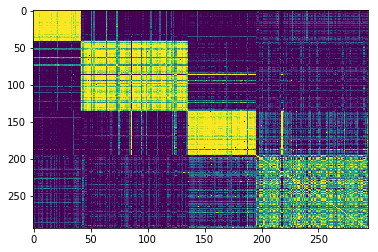

In [713]:
#Order cluster assignments
BLCA_CSN_NBS_cluster_assign_W.sort_values(inplace=True)
BLCA_CSN_NBS_cluster_assign.sort_values(inplace=True)

#Plot similarity of patient cluster assignments
plt.imshow(BLCA_CSN_NBS_cc_table.loc[BLCA_CSN_NBS_cluster_assign.index,BLCA_CSN_NBS_cluster_assign.index],
           aspect="auto")

In [714]:
# Discover consensus subnetworks to match consensus patient clusters
def consensus_networks(Hlist,Wlist,cluster_assignment_df=None,min_ratio = 2,min_percentile = 20,n_consensus_misses = 2):
    if cluster_assignment_df is None:
        from pyNBS import consensus_clustering as cc
        table, linkage, cluster_assignment_df = cc.consensus_hclust_hard(Hlist, k=Hlist[0].shape[1])
    #Set minimum hits
    min_hits = len(Hlist)-n_consensus_misses

    # Cluster assignments to disctionary
    cluster_assignments = {i:list(cluster_assignment_df.index[cluster_assignment_df==i])
     for i in cluster_assignment_df.unique()}

    # Instantiate results dictionary
    gene_subnetworks = {i:[] for i in list(cluster_assignments.keys())}


    #set iteration
    for index in range(len(Hlist)):

        #Identify tmp H matrix
        tmp_H = Hlist[index]
        pat_ix = [p for p in cluster_assignment_df.index if p in tmp_H.index]
        tmp_H = tmp_H.loc[pat_ix,:]

        #Identify tmp W matrix
        tmp_W = Wlist[index]

        #Iterate over each patient cluster
        for c in list(cluster_assignments.keys()):
            tmp_pats_c = list(set(tmp_H.index)&set(cluster_assignments[c]))
            if len(tmp_pats_c) == 0:
                print("No patients belonging to cluster {:d} in iteration {:d}".format(c,index))
                gene_subnetworks[c].append([])
                continue
                
            clust_match = tmp_H.loc[cluster_assignments[c],:].sum(axis=0).argmax()
            tmp_W_c = tmp_W.loc[:,[i for i in tmp_W.columns if i != clust_match]]

            #Set minimum ratio and value to select subnetwork genes
            min_value = np.percentile(tmp_W,min_percentile)

            #Subset genes by min_ratio
            tmp_diff = tmp_W.loc[:,clust_match]/tmp_W_c.mean(axis=1)
            tmp_diff.sort_values(ascending=False,inplace=True)

            #Subset genes by min_value
            subnetwork = tmp_diff.index[tmp_diff>min_ratio]
            subnetwork = subnetwork[tmp_W.loc[subnetwork,clust_match]>min_value]

            #Add subnetwork to dictionary
            gene_subnetworks[c].append(subnetwork)


    # Instantiate consensus networks dictionary
    consensus_subnetworks = {}

    # Identify consensus subnetworks
    for key in list(gene_subnetworks.keys()):
        tmp_count = Counter(np.hstack(gene_subnetworks[key]))
        tmp_mc = tmp_count.most_common()
        tmp_consensus = [tmp_mc[i][0] for i in range(len(tmp_mc)) if tmp_mc[i][1] >= min_hits]
        consensus_subnetworks[key] = tmp_consensus
        
    return consensus_subnetworks

In [715]:
consensus_subnetworks = consensus_networks(Hlist=BLCA_CSN_Hlist_ext,Wlist=BLCA_CSN_Wlist_ext,cluster_assignment_df=BLCA_CSN_NBS_cluster_assign,
                                           min_ratio = 2,min_percentile = 50,n_consensus_misses = 0.5*len(Hlist))
consensus_subnetworks_list = np.hstack([consensus_subnetworks[i] for i in list(consensus_subnetworks.keys())])


### Survival analysis

Additional details on the survival data file format is also describe on our Github wiki at: 
https://github.com/huangger/pyNBS/wiki/Patient-Survival-Data-File-Format

In [716]:
## load survival data
#survivalMMRF = pd.read_csv(os.path.join(os.path.expanduser("~"),"Desktop","miner2","data","survival","survivalIA12.csv"),index_col=0,header=0)
#survivalDfMMRF = survivalMMRF.iloc[:,0:2]
#survivalDfMMRF.columns = ["duration","observed"]

##generate Kaplan-Meier estimates
#kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
##generate GuanRank scores
#guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

#Format cluster assignments into dictionary
cluster_assignment_df = BLCA_CSN_NBS_cluster_assign
cluster_assignments = {i:list(cluster_assignment_df.index[cluster_assignment_df==i])
     for i in cluster_assignment_df.unique()}

In [717]:
cluster_assignment_df.to_csv(os.path.join(os.path.expanduser("~"),"Desktop","NBS_results","NBS_subtypes_k="+str(clusters)+".csv"))
miner.write_json(cluster_assignments,
                 os.path.join(os.path.expanduser("~"),"Desktop","NBS_results","NBS_subtypes_k="+str(clusters)+".json"))

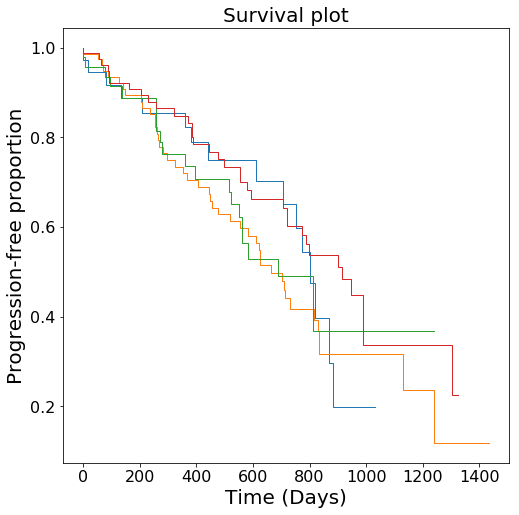

In [718]:
# Plot progression-free survival KM curves of NBS groups

srv = guanSurvivalDfMMRF.copy()
groups = [list(cluster_assignment_df.index[cluster_assignment_df==i])
     for i in cluster_assignment_df.unique()]
groups = [list(set(g)&set(srv.index)) for g in groups]
labels = np.arange(1,len(groups)+1).astype(str)

groups_for_plot = []
for i in range(len(groups)):
    if len(groups[i])>4:
        groups_for_plot.append(i)

groups = list(np.array(groups)[groups_for_plot])
labels = list(np.array(labels)[groups_for_plot])
plotName = os.path.join(os.path.expanduser("~"),"Desktop","NBS_results","NBS_survival_k="+str(clusters)+".pdf")

plt.figure(figsize=(8,8))
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)  
plt.ylabel("Progression-free proportion",FontSize=20)
plt.xlabel("Time (Days)",FontSize=20)
plt.title("Survival plot",FontSize=20)
_=plt.xticks(FontSize=16)
_=plt.yticks(FontSize=16)
plt.savefig(plotName,bbox_inches="tight")

## Read and explore survival results from file

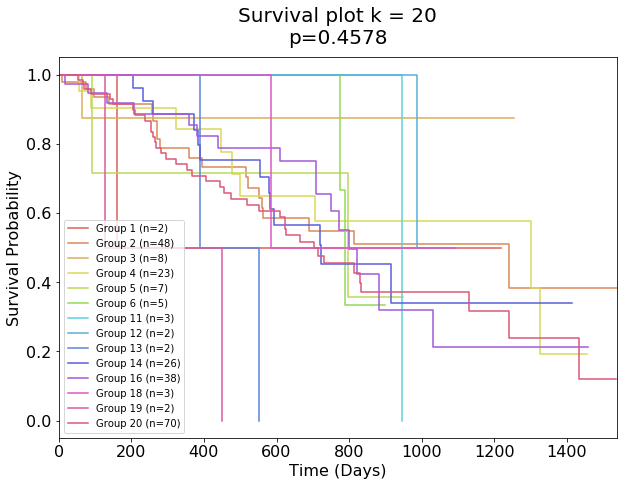

In [802]:
k = 20
cluster_assign = pd.read_csv(os.path.join(os.path.expanduser("~"),"Desktop","NBS_results",
                                          "NBS_subtypes_k="+str(k)+".csv"),index_col=0,header=None,squeeze=True)
cluster_assign.columns = ["name"]
#cluster_assign = cluster_assignment_df
surv = guanSurvivalDfMMRF.copy()
edits.cluster_kmplot(cluster_assign,surv,lr_test = True,verbose = False,tmax = -1)
plotName = os.path.join(os.path.expanduser("~"),"Desktop","NBS_results","NBS_survival_k="+str(k)+"_p.pdf")
plt.savefig(plotName,bbox_inches="tight")

## pyNBS archive

In [109]:
# Load survival Data
BLCA_surv_data = './Supplementary_Notebooks/Supplementary_Notebook_Data/BLCA.clin.merged.surv.txt'

Multi-Class Log-Rank P: 0.008906052510099963


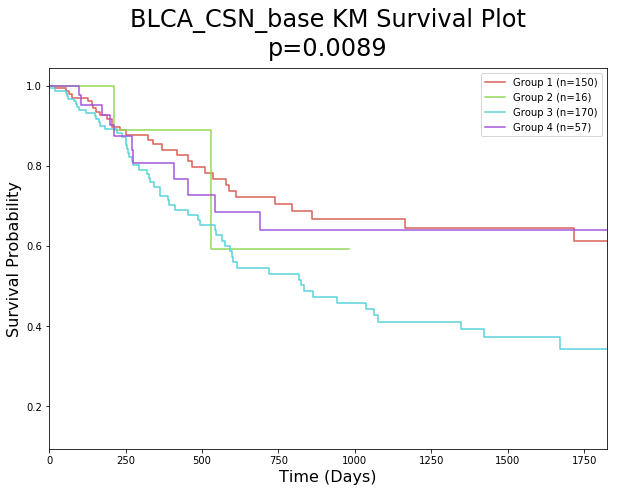

Kaplan Meier Plot constructed


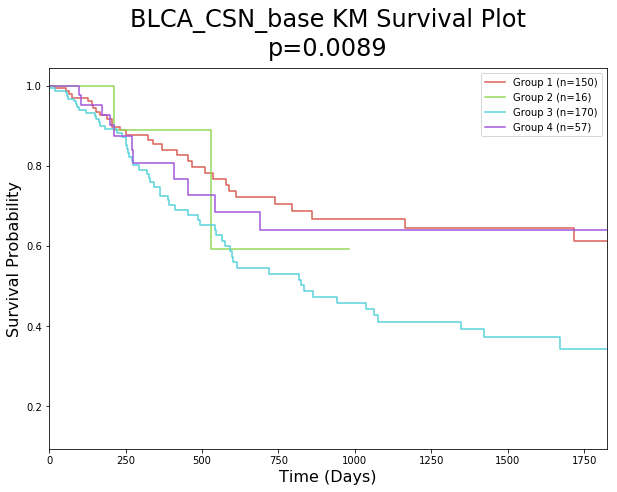

In [448]:
# Plot KM Plot for patient clusters
BLCA_CSN_p = plot.cluster_KMplot(BLCA_CSN_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

# pyNBS on BLCA with shuffled Cancer Subnetwork

In [11]:
# Load Shuffled version of Cancer Specific Network
CSNshuff = dit.load_network_file('./Supplementary_Notebook_Data/CancerSubnetwork.txt', degree_shuffle=True)

Network File Loaded: ./Supplementary_Notebook_Data/CancerSubnetwork.txt
Network shuffled: 34.4114289284 seconds. Edge similarity: 0.241762165388


In [12]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSNshuff'

In [13]:
# Constructing knnGlap
CSNshuff_knnGlap = core.network_inf_KNN_glap(CSNshuff)

Graph influence matrix calculated: 3.94558119774 seconds
Graph laplacian of KNN network from influence matrix calculated: 10.8507220745 seconds


In [14]:
# Construct network propagation kernel for CSNshuff
# Construct identity matrix of network
CSNshuff_network_nodes = CSNshuff.nodes()
CSNshuff_network_I = pd.DataFrame(np.identity(len(CSNshuff_network_nodes)), index=CSNshuff_network_nodes, columns=CSNshuff_network_nodes)
CSNshuff_kernel = prop.network_propagation(CSNshuff, CSNshuff_network_I, alpha=alpha, symmetric_norm=False)

Performing network propagation with alpha: 0.7
Network Propagation Complete: 8.0382771492 seconds


In [15]:
clusters, niter = 4, 100

# Run pyNBS
BLCA_CSNshuff_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_CSNshuff_Hlist.append(pyNBS_single.NBS_single(sm_mat, CSNshuff_knnGlap, propNet=CSNshuff, propNet_kernel=CSNshuff_kernel, k=clusters))

In [16]:
# Consensus Clustering
BLCA_CSNshuff_NBS_cc_table, BLCA_CSNshuff_NBS_cc_linkage, BLCA_CSNshuff_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSNshuff_Hlist, k=clusters, **save_args)

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned


Multi-Class Log-Rank P: 0.00831591713097
Kaplan Meier Plot constructed


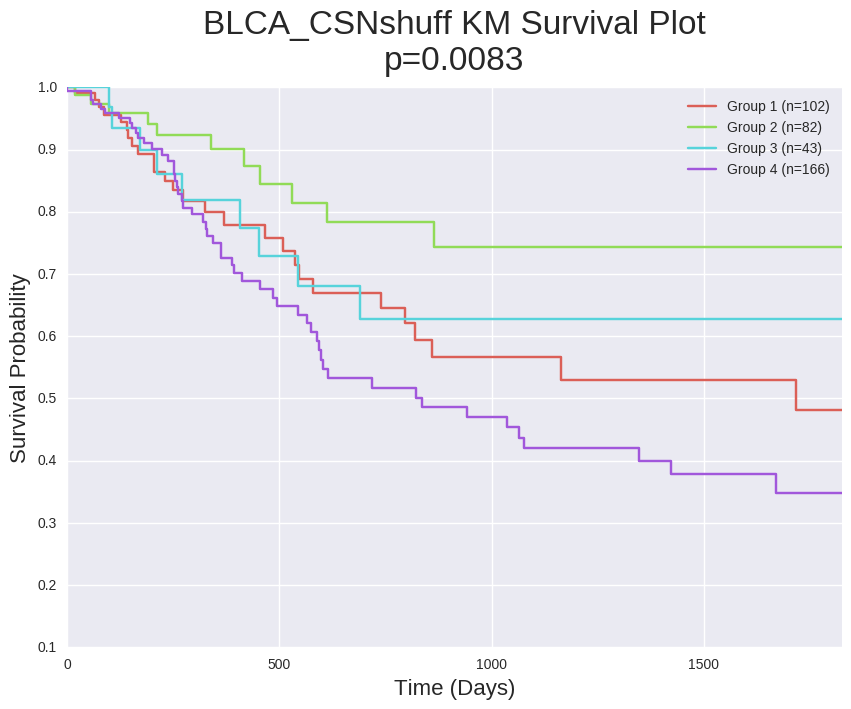

In [17]:
# Plot KM Plot for patient clusters
BLCA_CSNshuff_p = plot.cluster_KMplot(BLCA_CSNshuff_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [18]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSNshuff_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.554846013602
Adjusted Mutual Info Score is: 0.490671103422


In [19]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,88,63,0,5
Original pyNBS Cluster 2,4,8,1,6
Original pyNBS Cluster 3,9,2,1,145
Original pyNBS Cluster 4,1,9,41,10


In [20]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 526.318383321
Chi-Squared P-Value: 1.32534310419e-107


# pyNBS on BLCA with HM90

In [21]:
# Load top 10% of edges from HumanNet and convert those edges to HUGO Symbol
HM90 = dit.load_network_file('./Supplementary_Notebook_Data/HumanNet90_Symbol.txt')

Network File Loaded: ./Supplementary_Notebook_Data/HumanNet90_Symbol.txt


To perform the gene name conversions described for HM90, we used our [```gene_conversion_tools```](https://github.com/huangger/pyNBS/wiki/pyNBS.gene_conversion_tools) module in pyNBS.

In [22]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_HM90'

In [23]:
# Constructing knnGlap
HM90_knnGlap = core.network_inf_KNN_glap(HM90)

Graph influence matrix calculated: 23.710201025 seconds
Graph laplacian of KNN network from influence matrix calculated: 46.9573550224 seconds


In [24]:
# Construct network propagation kernel for HM90
# Construct identity matrix of network
HM90_network_nodes = HM90.nodes()
HM90_network_I = pd.DataFrame(np.identity(len(HM90_network_nodes)), index=HM90_network_nodes, columns=HM90_network_nodes)
HM90_kernel = prop.network_propagation(HM90, HM90_network_I, alpha=alpha, symmetric_norm=False)

Performing network propagation with alpha: 0.7
Network Propagation Complete: 113.823643923 seconds


In [25]:
clusters, niter = 4, 100

# Run pyNBS
BLCA_HM90_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_HM90_Hlist.append(pyNBS_single.NBS_single(sm_mat, HM90_knnGlap, propNet=HM90, propNet_kernel=HM90_kernel, k=clusters))

In [26]:
# Consensus Clustering
BLCA_HM90_NBS_cc_table, BLCA_HM90_NBS_cc_linkage, BLCA_HM90_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_HM90_Hlist, k=clusters, **save_args)

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned


Multi-Class Log-Rank P: 0.371743203315
Kaplan Meier Plot constructed


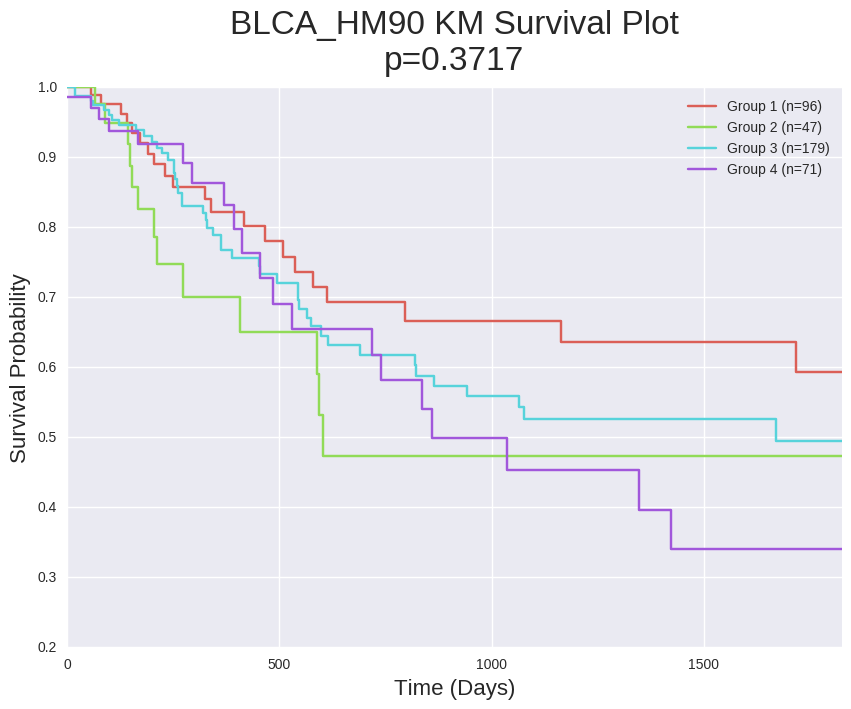

In [27]:
# Plot KM Plot for patient clusters
BLCA_HM90_p = plot.cluster_KMplot(BLCA_HM90_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [28]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_HM90_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.174265643299
Adjusted Mutual Info Score is: 0.170391172124


In [29]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,88,23,29,16
Original pyNBS Cluster 2,1,1,12,5
Original pyNBS Cluster 3,4,15,98,40
Original pyNBS Cluster 4,3,8,40,10


In [30]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 163.224827576
Chi-Squared P-Value: 1.58662786825e-30


# pyNBS on BLCA with no network propagation
Here, we perform the pyNBS algorithm using the BLCA data and default settings with k=4, but without performing any network propagation. The only place the network will be used is in constructing the regularization network for the network-regularized NMF step. The quantile normalization will be performed on the binary sub-sampled data.

In [31]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSN_noprop'

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned
Multi-Class Log-Rank P: 0.0077766885269
Kaplan Meier Plot constructed


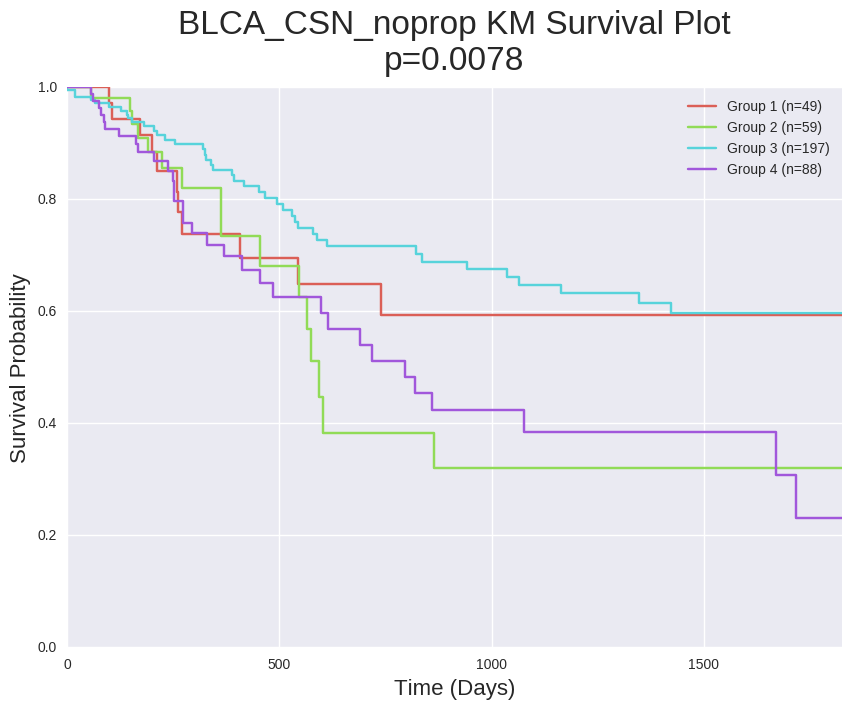

In [32]:
clusters, niters= 4, 100

# Run pyNBS
BLCA_CSN_noprop_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_CSN_noprop_Hlist.append(pyNBS_single.NBS_single(sm_mat, CSN_knnGlap, k=clusters))

# Consensus Clustering
BLCA_CSN_noprop_NBS_cc_table, BLCA_CSN_noprop_NBS_cc_linkage, BLCA_CSN_noprop_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSN_noprop_Hlist, k=clusters, **save_args)

# Plot KM Plot for patient clusters
BLCA_CSN_noprop_p = plot.cluster_KMplot(BLCA_CSN_noprop_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [33]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSN_noprop_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.120126994202
Adjusted Mutual Info Score is: 0.127767131714


In [34]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,3,17,109,27
Original pyNBS Cluster 2,2,4,9,4
Original pyNBS Cluster 3,9,35,61,52
Original pyNBS Cluster 4,35,3,18,5


In [35]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 166.951803729
Chi-Squared P-Value: 2.66113231387e-31


# pyNBS on BLCA with no network regularization
Here, we perform the pyNBS algorithm using the BLCA data and default settings with k=4, but without constructing the regularization for the network-regularized NMF. The somatic mutation data will still be propgated over the Cancer Subnetwork, but the regularization term in the [```mixed_netNMF```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.mixed_netNMF) step will be set to 0.

In [36]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSN_noreg'
# Setting lambda value (regularization constant) to 0
NBS_single_params = {'netNMF_lambda':'0'}

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned
Multi-Class Log-Rank P: 0.0132966217938
Kaplan Meier Plot constructed


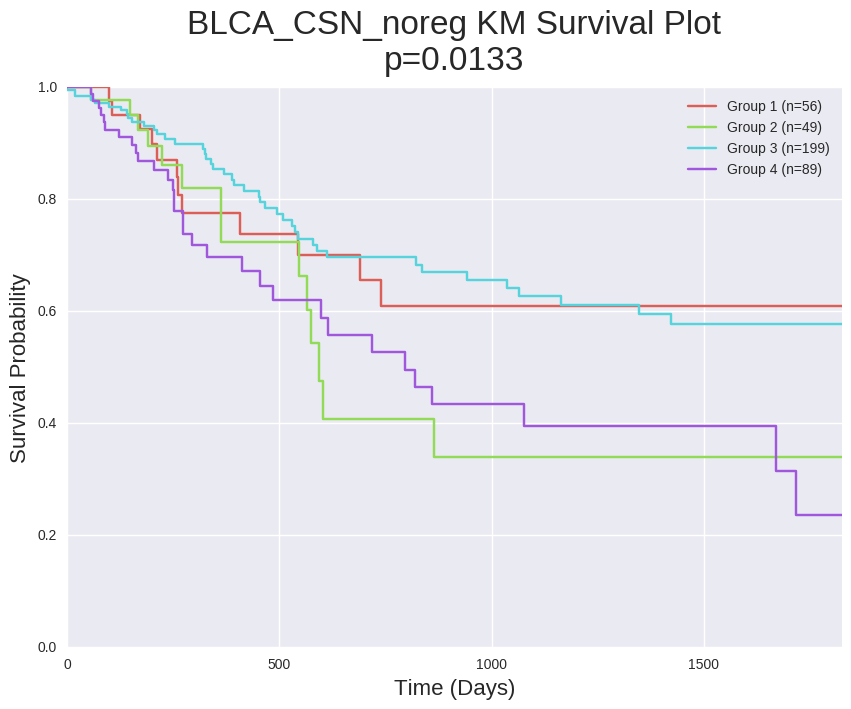

In [37]:
clusters, niters= 4, 100

# Run pyNBS
BLCA_CSN_noreg_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_CSN_noreg_Hlist.append(pyNBS_single.NBS_single(sm_mat, CSN_knnGlap, k=clusters, **NBS_single_params))

# Consensus Clustering
BLCA_CSN_noreg_NBS_cc_table, BLCA_CSN_noreg_NBS_cc_linkage, BLCA_CSN_noreg_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSN_noreg_Hlist, k=clusters, **save_args)

# Plot KM Plot for patient clusters
BLCA_CSN_noreg_p = plot.cluster_KMplot(BLCA_CSN_noreg_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [39]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSN_noreg_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.127131501712
Adjusted Mutual Info Score is: 0.130439735616


In [40]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,3,10,113,30
Original pyNBS Cluster 2,3,4,10,2
Original pyNBS Cluster 3,15,32,58,52
Original pyNBS Cluster 4,35,3,18,5


In [41]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 156.222826757
Chi-Squared P-Value: 4.52006092993e-29


# pyNBS on BLCA with no consensus clustering
Here, we perform the pyNBS algorithm using the BLCA data, the cancer subnetwork and default settings with k=4. However, we will perform the algorithm without any consensus clustering but rather set both subsampling parameters to 1.0 (see [```subsample_sm_mat```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.subsample_sm_mat) for more details). 

In [42]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSN_nocc'
# Setting subsampling parameters
NBS_single_params2 = {'pats_subsample_p':'1'}
NBS_single_params2 = {'gene_subsample_p':'1'}

Multi-Class Log-Rank P: 0.0162618798524
Kaplan Meier Plot constructed


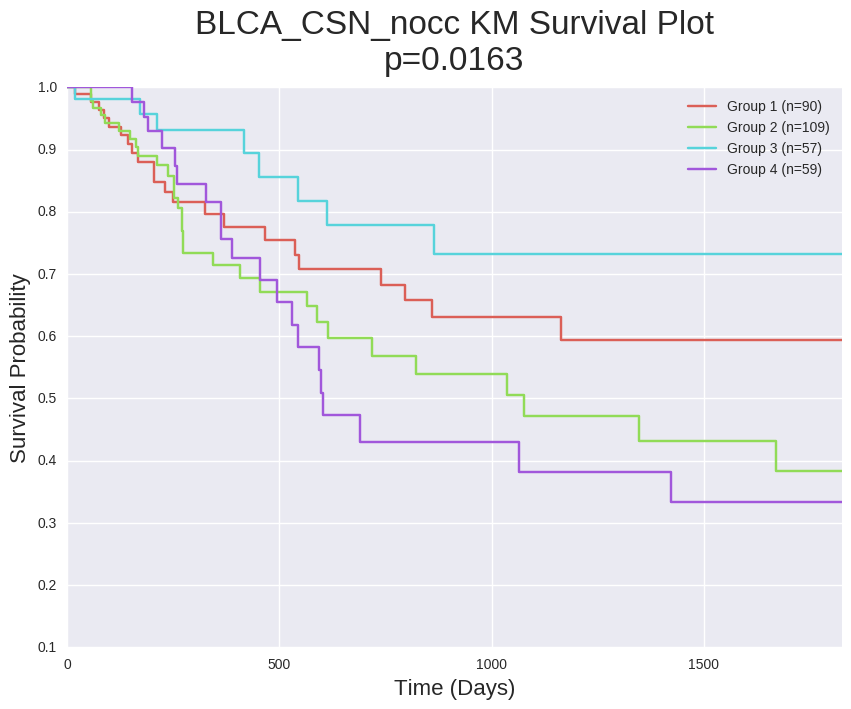

In [45]:
clusters, niters= 4, 100

# Run pyNBS
BLCA_CSN_nocc_H = pyNBS_single.NBS_single(sm_mat, CSN_knnGlap, propNet=CSN, propNet_kernel=CSN_kernel, k=clusters)

# Hard clustering (no consensus)
BLCA_CSN_nocc_H.columns = range(1,len(BLCA_CSN_nocc_H.columns)+1)
BLCA_CSN_nocc_cluster_assign_dict = {}
for pat in BLCA_CSN_nocc_H.index:
    BLCA_CSN_nocc_cluster_assign_dict[pat] = np.argmax(BLCA_CSN_nocc_H.ix[pat])
BLCA_CSN_nocc_cluster_assign = pd.Series(BLCA_CSN_nocc_cluster_assign_dict, name='CC Hard, k='+repr(clusters))
save_clusters_path = save_args['outdir']+str(save_args['job_name'])+'_cluster_assignments.csv'
BLCA_CSN_nocc_cluster_assign.to_csv(save_clusters_path)

# Plot KM Plot for patient clusters
BLCA_CSN_nocc_p = plot.cluster_KMplot(BLCA_CSN_nocc_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [46]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSN_nocc_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.304234730035
Adjusted Mutual Info Score is: 0.280458599074


In [47]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,78,6,35,7
Original pyNBS Cluster 2,1,3,5,9
Original pyNBS Cluster 3,10,76,1,38
Original pyNBS Cluster 4,1,24,16,5


In [48]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 211.946848022
Chi-Squared P-Value: 1.03113535351e-40
